# 친환경자동차 등록 대수 현황 및 친환경자동차 충전소 시각화

In [4]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt

### 2021 지역별 전기차 현황 데이터

In [5]:
# 전기차 현황 정보 불러오기 (2019-01-01 ~ 2022-03-01)
df = pd.read_csv('/content/한국전력공사_지역별 전기차 현황정보_20220429.csv', encoding='cp949')

# 컬럼명 변경
df.rename(columns = {'서울': '서울특별시', '인천': '인천광역시',
                     '경기': '경기도', '강원': '강원도',
                     '충북':'충청북도', '충남': '충청남도',
                     '대전': '대전광역시', '세종': '세종특별자치시',
                     '경북': '경상북도', '대구': '대구광역시',
                     '전북': '전라북도', '전남': '전라남도',
                     '광주': '광주광역시','경남': '경상남도',
                     '부산': '부산광역시', '울산': '울산광역시',
                     '제주':'제주특별자치도','합계':'합계'}, inplace = True)

In [ ]:
# 전기차 현황 정보 (2019-01-01 ~ 2022-03-01)
electric_vehicle_df = df[:]

# 합계 컬럼 삭제
electric_vehicle_df = df.drop(['합계'], axis = 1)

# 기준일이 2021-01-01 ~ 2021-12-01의 데이터만 수집
electric_vehicle_2021_df = electric_vehicle_df[electric_vehicle_df['기준일'].between('2021-01-01','2021-12-01')]

# 행과 열을 변경 컬럼명은 이전의 index로 사용
electric_vehicle_2021_df = electric_vehicle_2021_df.transpose().rename(columns = electric_vehicle_2021_df.iloc[0])
# index의 기준일 삭제
electric_vehicle_2021_df = electric_vehicle_2021_df.drop(electric_vehicle_2021_df.index[0])
# 합계를 생성 후 시도별 합계를 구하여 데이터 가공
electric_vehicle_2021_df['합계'] = electric_vehicle_2021_df.sum(axis = 1).astype('int64')

# index 초기화
electric_vehicle_2021_df.reset_index(inplace=True)
# index를 시도로 변경
electric_vehicle_2021_df.rename(columns = {'index': '시도'}, inplace=True)

g_geo = '/content/전국행정구역경계.json'
# 지도의 위경도, 백그라운드, 카메라 zoom 설정
electric_vehicle_status_map = folium.Map(location = [35.907757, 127.766922], tiles='Stamen Terrain', zoom_start = 6)

folium.Choropleth(geo_data = g_geo,
            data = electric_vehicle_2021_df,
            columns = ('시도', '합계'),
            #json의 명시된 properties의 CTP_KOR_NM을 시도와 비교한다.
            key_on = 'properties.CTP_KOR_NM', 
            fill_color='YlOrRd',
            ).add_to(electric_vehicle_status_map)

electric_vehicle_status_map.save('./electric_vehicle_status_map.html')
# https://chanwon-seo.github.io/Electric_vehicle_and_charging_station_analysis/charging_station_map.html
electric_vehicle_status_map

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


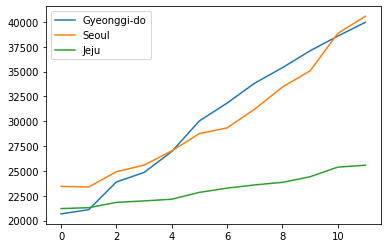

In [7]:
# 합계를 기준으로 정렬
electric_vehicle_2021_df = electric_vehicle_2021_df.sort_values(by = '합계', ascending=False)

#합계가 가장 높은 데이터만 추출
top_df3 = electric_vehicle_2021_df.iloc[:3] 

# 시도 열을 index
top_df3.set_index('시도', inplace=True)

# 합계 열 drop
top_df3.drop('합계', axis=1, inplace=True)

# 행과 열 뒤집기
top_df3 = top_df3.transpose()
top_df3.sort_index(inplace=True, ascending=False)
top_df3.reset_index(inplace=True, drop=True)

plt.plot(top_df3)
plt.legend(("Gyeonggi-do","Seoul", "Jeju"))
plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr70ndyzl/mbpi7ddx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr70ndyzl/ql2fpo0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66759', 'data', 'file=/tmp/tmpr70ndyzl/mbpi7ddx.json', 'init=/tmp/tmpr70ndyzl/ql2fpo0h.json', 'output', 'file=/tmp/tmpr70ndyzl/prophet_model

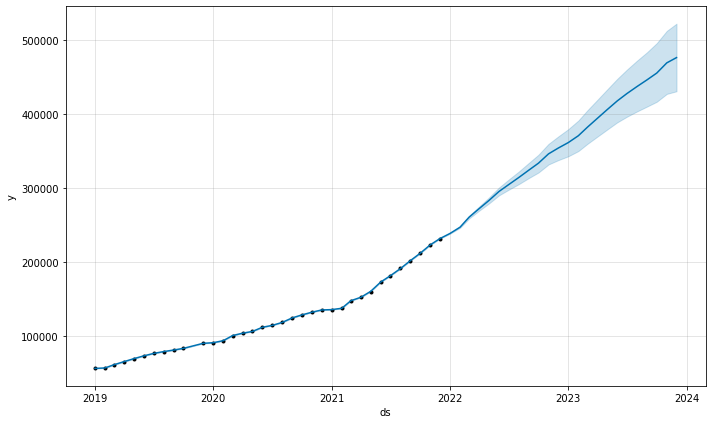

In [8]:
from prophet import Prophet
# 2019 ~ 2021년도 데이터 도출
electric_vehicle_2019_2021_df = df[df['기준일'].between('2019-01-01', '2021-12-01')]

# 데이터 정렬
electric_vehicle_2019_2021_df.sort_values('기준일',inplace=True)

# prophet을 사용하기 위해서는 컬럼을 변경 : 'ds', 'y'
prophet_data = electric_vehicle_2019_2021_df[['기준일','합계']]
prophet_data.columns = ['ds', 'y']

prophet = Prophet()
prophet.fit(prophet_data)
# 2019 ~ 2021년 데이터를 기준으로 24개월 후 시장 예측
future = prophet.make_future_dataframe(periods = 24, freq = 'MS')
prophet.predict(future)

pred = prophet.predict(future)
# 예측된 데이터 중 ds, yhat, yhat_lower, yhat_upper 도출
pred = pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet.plot(pred)

plt.show()

### 위경도를 이용한 전기차 충전소 지도 시각화

> background = GoogleMap

In [9]:
from folium.plugins import MarkerCluster

# 전기차 충전소 위경도 데이터 불러오기기
df1 = pd.read_csv('/content/한국전력공사_전기차충전소위경도_20220718.csv', encoding='cp949')

# 구글맵을 background로 사용
tiles = "http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}"
# 지도 위경도 설정, 카메라 설정, tiles는 구글맵
charging_station_map=folium.Map(location = [35.907757, 127.766922], zoom_start = 7, tiles = tiles, attr = 'Google')

In [ ]:
#MarkerCluster 를 이용하면 가까운 거리의 Marker들을 군집시켜서 해당 건수를 표현해준다
marker_cluster = MarkerCluster().add_to(charging_station_map)

for name, lat, lng in zip(df1['충전소명'], df1['경도'], df1['위도']):
  folium.Marker([lat, lng], popup='<b>'+name+'</b>').add_to(marker_cluster)

charging_station_map.save('./charging_station_map.html')
# https://chanwon-seo.github.io/Electric_vehicle_and_charging_station_analysis/electric_vehicle_status_map.html
charging_station_map

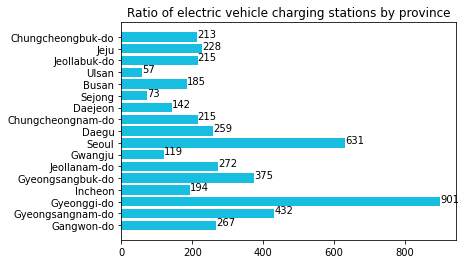

In [23]:
# matplotlib 한글 지원 문제로 인한 시도별 영문
df_columns = ['Gangwon-do', 'Gyeongsangnam-do', 'Gyeonggi-do', 'Incheon', 'Gyeongsangbuk-do', 'Jeollanam-do', 
              'Gwangju', 'Seoul', 'Daegu', 'Chungcheongnam-do', 'Daejeon', 'Sejong', 'Busan', 'Ulsan', 'Jeollabuk-do',
              'Jeju','Chungcheongbuk-do']
df1_list = df1['시도'].value_counts(sort = False)

y = np.arange(len(df1_list))

plt.title("Ratio of electric vehicle charging stations by province") 

plt.barh(y, df1_list, color='#17bedf')
plt.yticks(y, df_columns)

for idx, value in enumerate(df1_list): 
  plt.text(value + 0.5, idx, str(value))
plt.show()

In [ ]:
!pip install pyecharts==0.5.11
!pip install pyecharts-snapshot

In [17]:
# 전기차 충전소 시간별 충전부하 데이터
hours_df = pd.read_csv('/content/한국전력공사_EV시간대별 충전부하_20220601.csv')
# 2021년도 데이터 추출
hours_df = hours_df[hours_df['년월']<='2021-12-01']

        년월 급속/완속     0시     1시     2시     3시     4시     5시     6시      7시  \
0  2021-01    급속  59160  44600  27600  21240  41280  46320  82280  141680   
1  2021-01    완속  15148  13748   9219   4123   2128   2240   3962    6986   
2  2021-02    급속  58440  43360  26960  19120  30760  41880  77960  136080   
3  2021-02    완속  14350  13804   8365   4270   2240   2100   3913    8372   
4  2021-03    급속  63600  46000  30080  22040  39000  51640  97960  159080   

   ...     14시     15시     16시     17시     18시     19시     20시     21시  \
0  ...  407280  423320  425600  389640  349600  288560  242000  199160   
1  ...   32501   39732   47502   60319   75103   69832   59801   52297   
2  ...  357720  365560  364440  333800  316720  264880  215040  178320   
3  ...   29071   36743   43708   52766   65170   63903   57659   52136   
4  ...  358160  380680  378080  367560  351960  301080  241920  187640   

      22시     23시  
0  155600  114480  
1   47670   44723  
2  143000  106680  
3   45864   

In [14]:
from pyecharts import Bar, Pie, Timeline, Style, Grid

# 월별 급속 데이터
rapid = hours_df[hours_df['급속/완속'] == '급속']
rapid = rapid.reset_index(drop = True)

# 월별 완속 데이터
slow = hours_df[hours_df['급속/완속'] == '완속']
slow = slow.reset_index(drop=True)

time = hours_df.columns.to_list()

del time[0:2]

In [21]:
rapid_1 = rapid.iloc[0,2:].to_list()
rapid_2 = rapid.iloc[1,2:].to_list()
rapid_3 = rapid.iloc[2,2:].to_list()
rapid_4 = rapid.iloc[3,2:].to_list()
rapid_5 = rapid.iloc[4,2:].to_list()
rapid_6 = rapid.iloc[5,2:].to_list()
rapid_7 = rapid.iloc[6,2:].to_list()
rapid_8 = rapid.iloc[7,2:].to_list()
rapid_9 = rapid.iloc[8,2:].to_list()
rapid_10 = rapid.iloc[9,2:].to_list()
rapid_11 = rapid.iloc[10,2:].to_list()
rapid_12 = rapid.iloc[11,2:].to_list()
print("급속 1월")
print(rapid_1)

slow_1 = slow.iloc[0,2:].to_list()
slow_2 = slow.iloc[1,2:].to_list()
slow_3 = slow.iloc[2,2:].to_list()
slow_4 = slow.iloc[3,2:].to_list()
slow_5 = slow.iloc[4,2:].to_list()
slow_6 = slow.iloc[5,2:].to_list()
slow_7 = slow.iloc[6,2:].to_list()
slow_8 = slow.iloc[7,2:].to_list()
slow_9 = slow.iloc[8,2:].to_list()
slow_10 = slow.iloc[9,2:].to_list()
slow_11 = slow.iloc[10,2:].to_list()
slow_12 = slow.iloc[11,2:].to_list()
print("완속 1월")
print(slow_1)

급속 1월
[59160, 44600, 27600, 21240, 41280, 46320, 82280, 141680, 230600, 283360, 319200, 373480, 410840, 394240, 407280, 423320, 425600, 389640, 349600, 288560, 242000, 199160, 155600, 114480]
완속 1월
[15148, 13748, 9219, 4123, 2128, 2240, 3962, 6986, 13272, 17857, 22141, 26761, 28070, 28091, 32501, 39732, 47502, 60319, 75103, 69832, 59801, 52297, 47670, 44723]


In [22]:
bar_1 = Bar("시간대별 충전 부하량",'1월')
bar_1.add('급속', time, rapid_1, is_stack = True)
bar_1.add('완속', time, slow_1, is_stack = True)

bar_2 = Bar("시간대별 충전 부하량",'2월')
bar_2.add('급속', time, rapid_2, is_stack = True)
bar_2.add('완속', time, slow_2, is_stack = True)

bar_3 = Bar("시간대별 충전 부하량",'3월')
bar_3.add('급속', time, rapid_3, is_stack = True)
bar_3.add('완속', time, slow_3, is_stack = True)

bar_4 = Bar("시간대별 충전 부하량",'4월')
bar_4.add('급속', time, rapid_4, is_stack = True)
bar_4.add('완속', time, slow_4, is_stack = True)

bar_5 = Bar("시간대별 충전 부하량",'5월')
bar_5.add('급속', time, rapid_5, is_stack = True)
bar_5.add('완속', time, slow_5, is_stack = True)

bar_6 = Bar("시간대별 충전 부하량",'6월')
bar_6.add('급속', time, rapid_6, is_stack = True)
bar_6.add('완속', time, slow_6, is_stack = True)

bar_7 = Bar("시간대별 충전 부하량",'7월')
bar_7.add('급속', time, rapid_7, is_stack = True)
bar_7.add('완속', time, slow_7, is_stack = True)

bar_8 = Bar("시간대별 충전 부하량",'8월')
bar_8.add('급속', time, rapid_8, is_stack = True)
bar_8.add('완속', time, slow_8, is_stack = True)

bar_9 = Bar("시간대별 충전 부하량",'9월')
bar_9.add('급속', time, rapid_9, is_stack = True)
bar_9.add('완속', time, slow_9, is_stack = True)

bar_10 = Bar("시간대별 충전 부하량",'10월')
bar_10.add('급속', time, rapid_10, is_stack = True)
bar_10.add('완속', time, slow_10, is_stack = True)

bar_11 = Bar("시간대별 충전 부하량",'11월')
bar_11.add('급속', time, rapid_11, is_stack = True)
bar_11.add('완속', time, slow_11, is_stack = True)

bar_12 = Bar("시간대별 충전 부하량",'12월')
bar_12.add('급속', time, rapid_12, is_stack = True)
bar_12.add('완속', time, slow_12, is_stack = True)

timeline = Timeline(is_auto_play=True, timeline_bottom = -5, width = 900)
timeline.add(bar_1, '1월')
timeline.add(bar_2, '2월')
timeline.add(bar_3, '3월')
timeline.add(bar_4, '4월')
timeline.add(bar_5, '5월')
timeline.add(bar_6, '6월')
timeline.add(bar_7, '7월')
timeline.add(bar_8, '8월')
timeline.add(bar_9, '9월')
timeline.add(bar_10, '10월')
timeline.add(bar_11, '11월')
timeline.add(bar_12, '12월')
# https://chanwon-seo.github.io/Electric_vehicle_and_charging_station_analysis/charge_load_per_hour.html
timeline.render('charge_load_per_hour.html')